Import relevant packages

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import json
import numpy as np
import random
import os

Set up data loading functions.

In [2]:
tf.__version__
seed = 18
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(random)

Load data.

In [3]:
names = []

with os.scandir('training/') as entries:
    for entry in entries:
        names.append("training/"+entry.name)

#with os.scandir('test/') as entries:
#    for entry in entries:
#        names.append("test/"+entry.name)

In [14]:
def load(name):
    X = []
    Y = []
    with open(name) as json_file:
        data = json.load(json_file) 
        l = len(data['train'])
        i = 0
        for t in data['train']:
            i += 1
            
            cX = np.zeros((30, 30, channels))
            cY = np.zeros((30, 30, channels))
            
            cin = np.array(t['input'])
            cinr = np.full((30, 30), -1)
            cinr[:cin.shape[0], :cin.shape[1]] = cin
            cX[:, :, 0] = cinr
            #! Clone?
            cX[:, :, 1] = cinr
            
            cout = np.array(t['output'])
            coutr = np.full((30, 30), -1)
            coutr[:cout.shape[0], :cout.shape[1]] = cout
            cY[:, :, 0] = coutr
            #! Clone?
            cY[:, :, 1] = coutr
            X.append(cX)
            Y.append(cY)
            
        for t in data['test']:
            i += 1
            
            cX = np.zeros((30, 30, channels))
            cY = np.zeros((30, 30, channels))
            
            cin = np.array(t['input'])
            cinr = np.full((30, 30), -1)
            cinr[:cin.shape[0], :cin.shape[1]] = cin
            cX[:, :, 0] = cinr
            #! Clone?
            cX[:, :, 1] = cinr
            
            cout = np.array(t['output'])
            coutr = np.full((30, 30), -1)
            coutr[:cout.shape[0], :cout.shape[1]] = cout
            cY[:, :, 0] = coutr
            #! Clone?
            cY[:, :, 1] = coutr
            
            X.append(cX)
            Y.append(cY)

    return [np.array(X), np.array(Y)]

In [5]:
import matplotlib.pyplot as plt

def plot(inp):
    plt.imshow(inp[:, :, 0].reshape(30, 30))
    plt.colorbar()
    plt.show()

def plotf(inp):
    plt.imshow(inp)
    plt.colorbar()
    plt.show()

In [6]:
def loss_f(x, y):
    return tf.reduce_mean(tf.square(x[:, :, :, 0]-y[:, :, :, 0]))

In [27]:
def train(model, ctask, epochs, iterations, channels, verbose=False, validate=False, wholetask=None):
    trainer = tf.keras.optimizers.Adam()

    origx = ctask[0]
    x = origx.copy()
    y = ctask[1]

    mask = np.zeros((x.shape[0], 30, 30, channels))
    mask[:, :, :, 1] = 1
    xl2 = origx*mask

    for k in range(epochs):
        x = origx.copy()
        with tf.GradientTape() as g:
            for i in tf.range(iterations):
                dx = model(x)
                x = x+(dx*1)
                #x = x*(1-mask)+xl2
            loss = loss_f(x, y)
            grads = g.gradient(loss, model.weights)
            #grads = [g/(tf.norm(g)+1e-8) for g in grads]
            trainer.apply_gradients(zip(grads, model.weights))
        if k%5 == 0:
            if verbose:
                generated = np.clip(np.round(generate(model, wholetask[0], channels, iterations)), -1, 9)
                groundtruth = wholetask[1]
                valacc = testacc(generated, groundtruth)
                plot(generated[-1])
                plot(generated[1])
                print("LOSS AT EPOCH "+str(k)+": "+str(loss.numpy())+" TRAIN ACCURACY: "+str(np.mean(valacc[0:-1]))+" VALIDATION ACCURACY: "+str(valacc[-1]))
    return model

In [28]:
def generate(model, cin, channels, iterations):
    mask = np.zeros((cin.shape[0], 30, 30, channels))
    mask[:, :, :, 1] = 1
    xl2 = cin*mask
    
    for i in range(iterations):
        dx = model(cin)
        cin = cin+(dx*1)
        #cin = cin*(1-mask)+xl2
        if i%10 == 0:
            pass
            #toprint = cin.numpy()[0]
            #plot(toprint)
    
    toprint = cin.numpy()
    return toprint

In [9]:
def testacc(generated, groundtruth):
    print(generated.shape)
    generated = generated[:, :, :, 0]
    groundtruth = groundtruth[:, :, :, 0]
    same = (generated==groundtruth).astype(int)
    mask = (groundtruth != -1).astype(int)
    same *= mask
    same = np.sum(same, axis=(1, 2))
    print(same, np.count_nonzero(mask, axis=(1, 2)))
    same = same/np.count_nonzero(mask, axis=(1, 2))
    return same

In [10]:
tf.get_logger().setLevel('ERROR')
def test(ntasks, channels, filters, perceptionsize, neurons, epochs, iterations, plotting):
    tasks = random.sample(names, k=ntasks)
    avgacc = 0
    i = 0
    for task in tasks:
        i += 1
        model = tf.keras.Sequential([
            tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
            tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
            tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        ctask = load(task)
        cin = [ctask[0][0:-1], ctask[1][0:-1]]
        ctest = [ctask[0][-1], ctask[1][-1]]
        model = train(model, cin, epochs, iterations, channels, False, False, ctask)
        generated = np.clip(np.round(generate(model, np.array([ctest[0]]), channels, iterations)), -1, 9)
        groundtruth = ctest[1]
        if plotting:
            plot(generated)
            plot(groundtruth)
        acc = testacc(generated, groundtruth)
        avgacc += acc
        print("CURRENT ACCURACY "+str((acc*100)))
    avgacc /= ntasks
    return avgacc

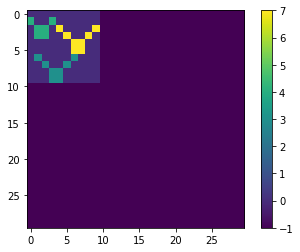

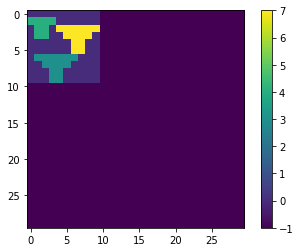

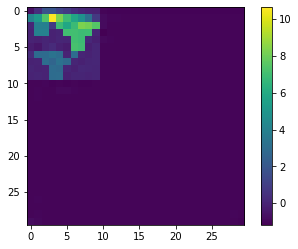

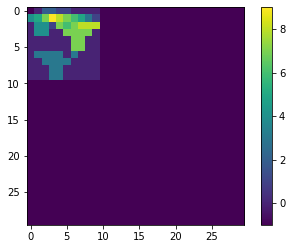

In [29]:
models = []
modelcount = 1

ntasks = 5
channels = 18
filters = 3
perceptionsize = 3
neurons = 128
epochs = 200
iterations = 25

ctask = load(names[104])
cin = [ctask[0][0:-1], ctask[1][0:-1]]
ctest = [ctask[0][-1], ctask[1][-1]]
plot(ctest[0])
plot(ctest[1])

outs = []

for i in range(modelcount):
    model = tf.keras.Sequential([
        tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
        tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
        tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
    ])
    model = train(model, cin, epochs, iterations, channels, False, False, ctask)
    out = generate(model, np.array([ctest[0]]), channels, iterations)[0]
    outs.append(out)
    plot(out)

outs = np.array(outs)
fout = np.clip(np.round(np.mean(outs, axis=0)), -1, 9)
plot(fout)

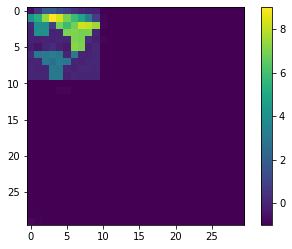

In [32]:
fout = np.clip(np.round(np.mean(outs, axis=0)), -1, 9)
plot(fout)

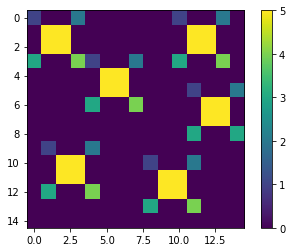

|100200000010020|055000000005500|055000000005500|300410020030040|000005500000000|000005500001002|000030040000550|000000000000550|000000000003003|010020000000000|005500001002000|005500000550000|030040000550000|000000003004000|000000000000000|


In [132]:
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

final = fout[:, :, 0]
x = np.argmin(final[0, :])
y = np.argmin(final[:, 0])
cropped = final[:y, :x]
plotf(cropped)

finalout = flattener(cropped.astype(int).tolist())
print(finalout)

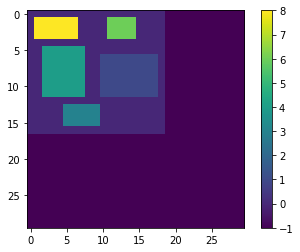

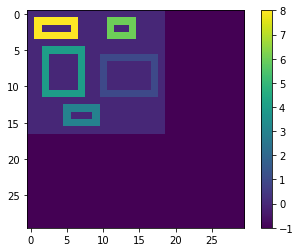

(4, 30, 30, 18)
[229  50 106 253] [288  56 132 323]


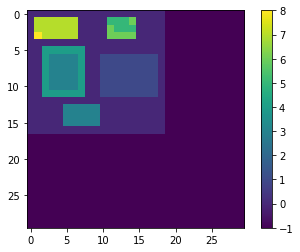

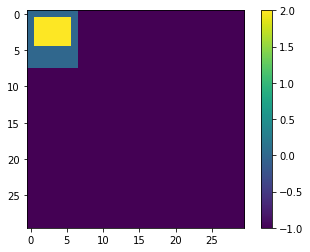

LOSS AT EPOCH 0: 0.45259258 TRAIN ACCURACY: 0.8303421115921115 VALIDATION ACCURACY: 0.7832817337461301
(4, 30, 30, 18)
[138  37  47 179] [288  56 132 323]


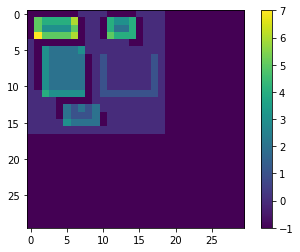

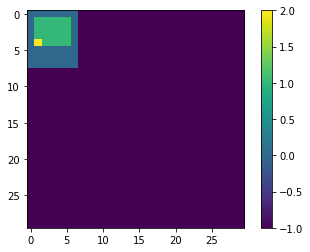

LOSS AT EPOCH 5: 0.26192346 TRAIN ACCURACY: 0.49864718614718617 VALIDATION ACCURACY: 0.5541795665634675
(4, 30, 30, 18)
[165  41  57 191] [288  56 132 323]


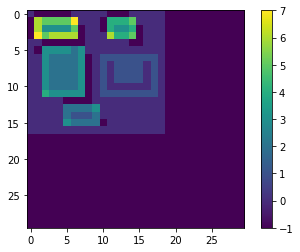

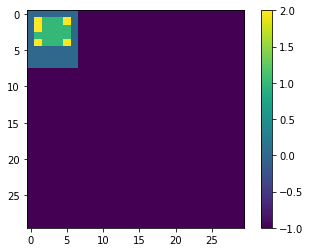

LOSS AT EPOCH 10: 0.22851452 TRAIN ACCURACY: 0.5789592352092352 VALIDATION ACCURACY: 0.5913312693498453
(4, 30, 30, 18)
[198  49  75 210] [288  56 132 323]


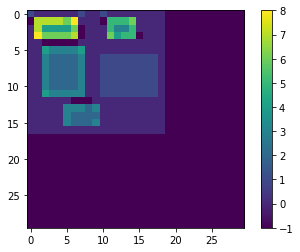

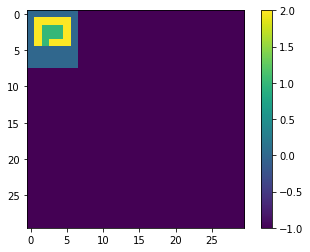

LOSS AT EPOCH 15: 0.1759926 TRAIN ACCURACY: 0.7102272727272728 VALIDATION ACCURACY: 0.6501547987616099
(4, 30, 30, 18)
[198  48  76 233] [288  56 132 323]


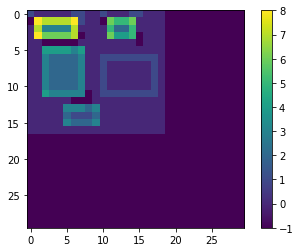

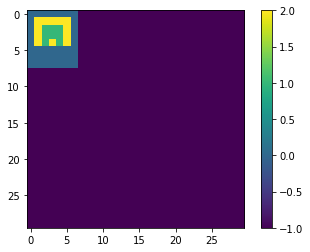

LOSS AT EPOCH 20: 0.13359305 TRAIN ACCURACY: 0.7068001443001443 VALIDATION ACCURACY: 0.7213622291021672
(4, 30, 30, 18)
[187  50  77 224] [288  56 132 323]


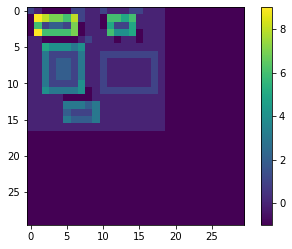

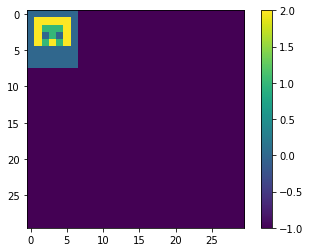

LOSS AT EPOCH 25: 0.09714403 TRAIN ACCURACY: 0.7084986772486773 VALIDATION ACCURACY: 0.6934984520123839
(4, 30, 30, 18)
[198  54  74 238] [288  56 132 323]


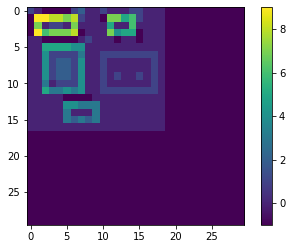

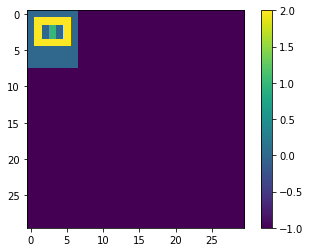

LOSS AT EPOCH 30: 0.078610696 TRAIN ACCURACY: 0.737463924963925 VALIDATION ACCURACY: 0.7368421052631579
(4, 30, 30, 18)
[213  55  82 246] [288  56 132 323]


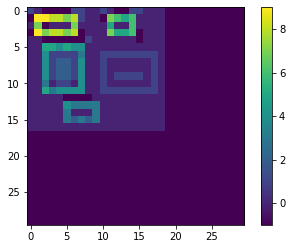

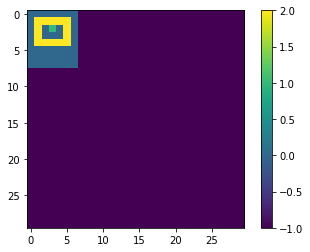

LOSS AT EPOCH 35: 0.065236315 TRAIN ACCURACY: 0.7809794372294373 VALIDATION ACCURACY: 0.7616099071207431
(4, 30, 30, 18)
[232  54  93 263] [288  56 132 323]


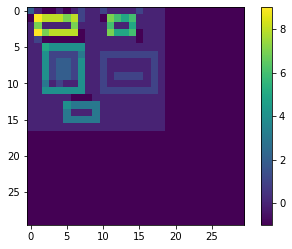

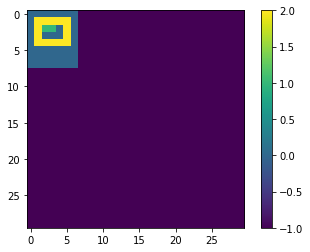

LOSS AT EPOCH 40: 0.052173253 TRAIN ACCURACY: 0.8247955747955747 VALIDATION ACCURACY: 0.8142414860681114
(4, 30, 30, 18)
[235  54  98 274] [288  56 132 323]


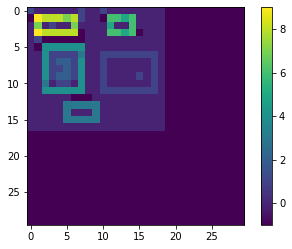

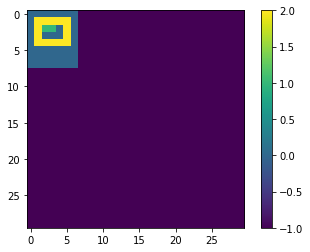

LOSS AT EPOCH 45: 0.04152726 TRAIN ACCURACY: 0.8408940596440596 VALIDATION ACCURACY: 0.848297213622291
(4, 30, 30, 18)
[246  55 103 285] [288  56 132 323]


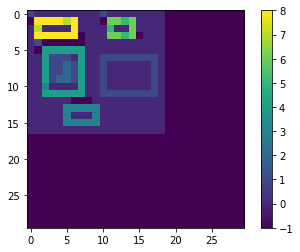

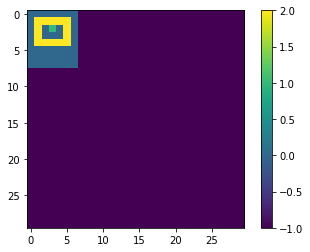

LOSS AT EPOCH 50: 0.0329891 TRAIN ACCURACY: 0.8722041847041847 VALIDATION ACCURACY: 0.8823529411764706
(4, 30, 30, 18)
[250  55 110 288] [288  56 132 323]


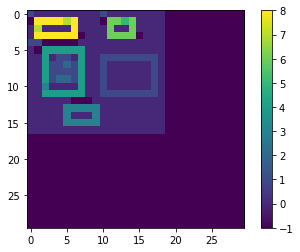

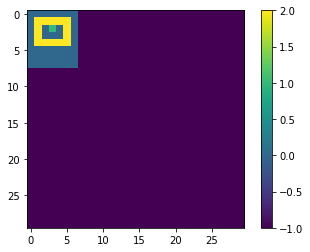

LOSS AT EPOCH 55: 0.025065867 TRAIN ACCURACY: 0.894510582010582 VALIDATION ACCURACY: 0.891640866873065
(4, 30, 30, 18)
[259  56 116 290] [288  56 132 323]


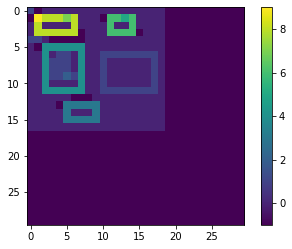

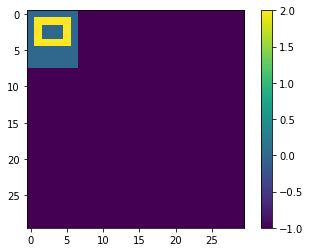

LOSS AT EPOCH 60: 0.01939153 TRAIN ACCURACY: 0.9260311447811448 VALIDATION ACCURACY: 0.8978328173374613
(4, 30, 30, 18)
[263  56 118 297] [288  56 132 323]


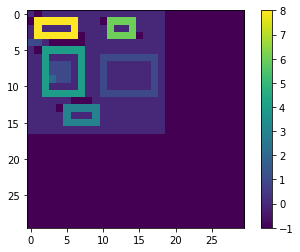

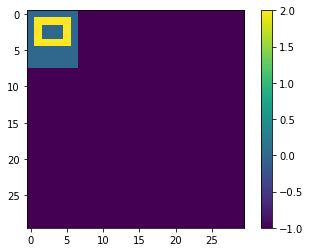

LOSS AT EPOCH 65: 0.015082608 TRAIN ACCURACY: 0.9357112794612794 VALIDATION ACCURACY: 0.9195046439628483
(4, 30, 30, 18)
[269  56 121 300] [288  56 132 323]


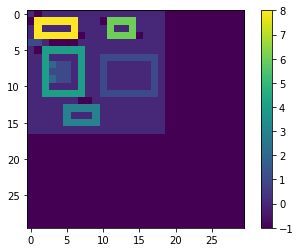

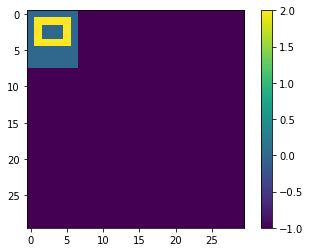

LOSS AT EPOCH 70: 0.01187617 TRAIN ACCURACY: 0.9502314814814814 VALIDATION ACCURACY: 0.9287925696594427
(4, 30, 30, 18)
[272  56 129 302] [288  56 132 323]


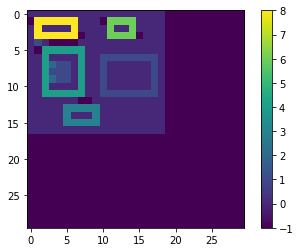

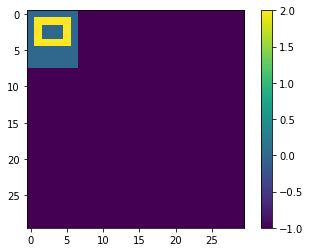

LOSS AT EPOCH 75: 0.009325476 TRAIN ACCURACY: 0.9739057239057239 VALIDATION ACCURACY: 0.934984520123839
(4, 30, 30, 18)
[277  56 132 305] [288  56 132 323]


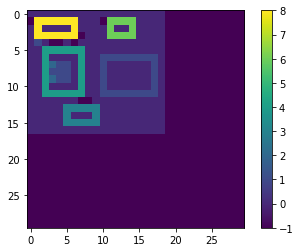

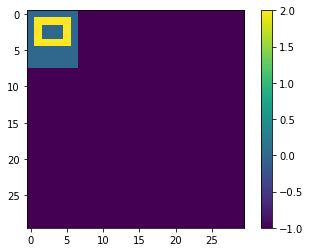

LOSS AT EPOCH 80: 0.0075295884 TRAIN ACCURACY: 0.9872685185185185 VALIDATION ACCURACY: 0.9442724458204335
(4, 30, 30, 18)
[278  56 132 308] [288  56 132 323]


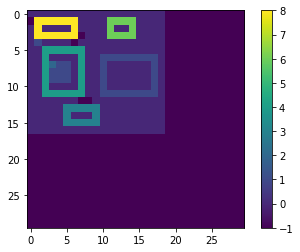

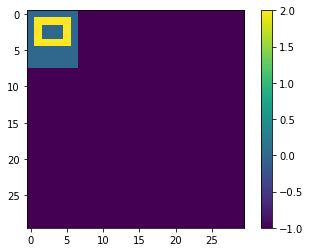

LOSS AT EPOCH 85: 0.006125823 TRAIN ACCURACY: 0.9884259259259259 VALIDATION ACCURACY: 0.9535603715170279
(4, 30, 30, 18)
[280  56 132 309] [288  56 132 323]


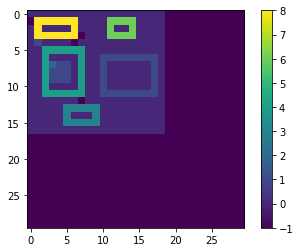

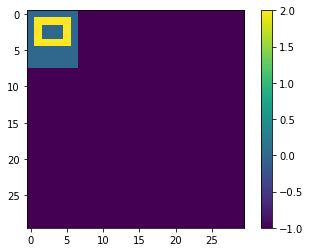

LOSS AT EPOCH 90: 0.005070586 TRAIN ACCURACY: 0.9907407407407408 VALIDATION ACCURACY: 0.9566563467492261
(4, 30, 30, 18)
[281  56 132 310] [288  56 132 323]


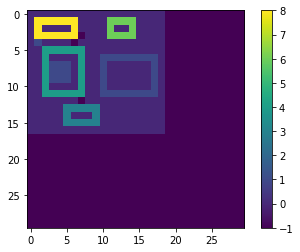

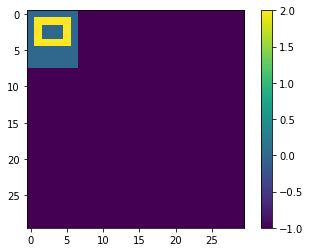

LOSS AT EPOCH 95: 0.0043181577 TRAIN ACCURACY: 0.9918981481481483 VALIDATION ACCURACY: 0.9597523219814241
(4, 30, 30, 18)
[281  56 132 311] [288  56 132 323]


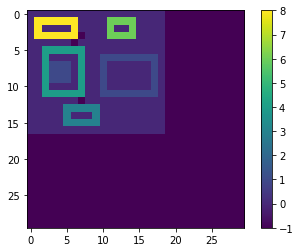

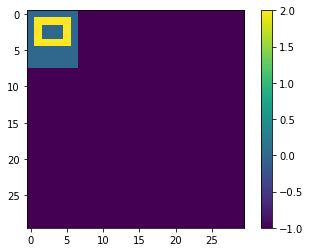

LOSS AT EPOCH 100: 0.0037583292 TRAIN ACCURACY: 0.9918981481481483 VALIDATION ACCURACY: 0.9628482972136223
(4, 30, 30, 18)
[281  56 132 311] [288  56 132 323]


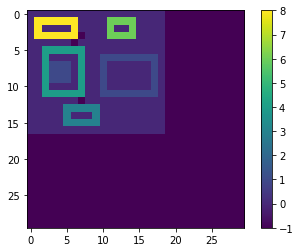

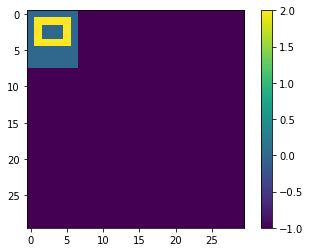

LOSS AT EPOCH 105: 0.0033145759 TRAIN ACCURACY: 0.9918981481481483 VALIDATION ACCURACY: 0.9628482972136223
(4, 30, 30, 18)
[282  56 132 311] [288  56 132 323]


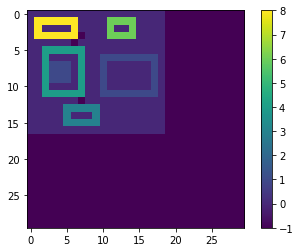

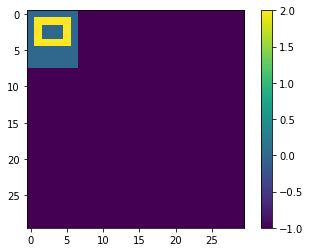

LOSS AT EPOCH 110: 0.0029542441 TRAIN ACCURACY: 0.9930555555555555 VALIDATION ACCURACY: 0.9628482972136223
(4, 30, 30, 18)
[282  56 132 311] [288  56 132 323]


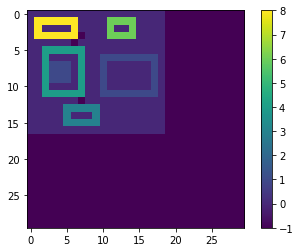

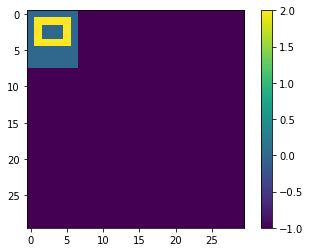

LOSS AT EPOCH 115: 0.002653932 TRAIN ACCURACY: 0.9930555555555555 VALIDATION ACCURACY: 0.9628482972136223
(4, 30, 30, 18)
[282  56 132 312] [288  56 132 323]


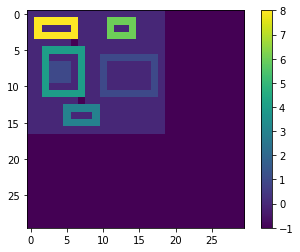

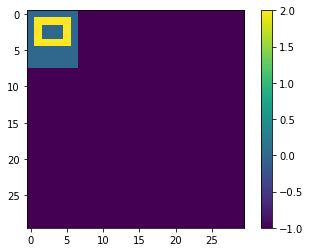

LOSS AT EPOCH 120: 0.0024003836 TRAIN ACCURACY: 0.9930555555555555 VALIDATION ACCURACY: 0.9659442724458205
(4, 30, 30, 18)
[282  56 132 312] [288  56 132 323]


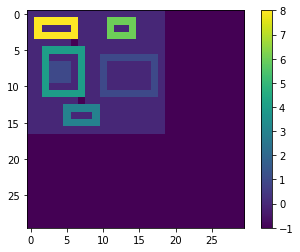

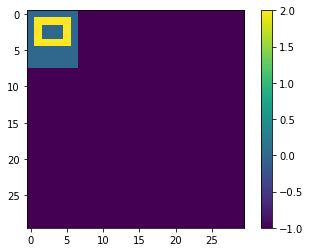

LOSS AT EPOCH 125: 0.0021812685 TRAIN ACCURACY: 0.9930555555555555 VALIDATION ACCURACY: 0.9659442724458205
(4, 30, 30, 18)
[282  56 132 311] [288  56 132 323]


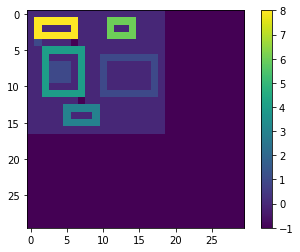

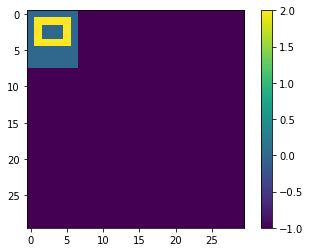

LOSS AT EPOCH 130: 0.0019956613 TRAIN ACCURACY: 0.9930555555555555 VALIDATION ACCURACY: 0.9628482972136223
(4, 30, 30, 18)
[282  56 132 311] [288  56 132 323]


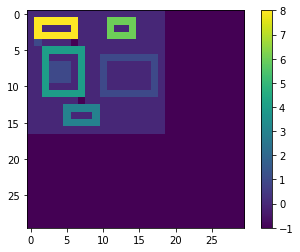

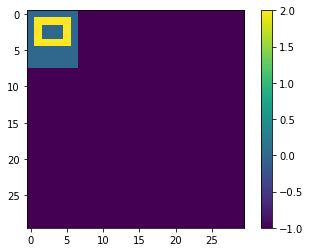

LOSS AT EPOCH 135: 0.001839103 TRAIN ACCURACY: 0.9930555555555555 VALIDATION ACCURACY: 0.9628482972136223
(4, 30, 30, 18)
[282  56 132 311] [288  56 132 323]


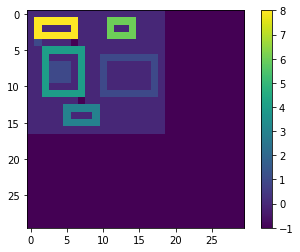

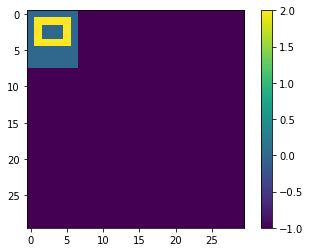

LOSS AT EPOCH 140: 0.0017031543 TRAIN ACCURACY: 0.9930555555555555 VALIDATION ACCURACY: 0.9628482972136223
(4, 30, 30, 18)
[282  56 132 311] [288  56 132 323]


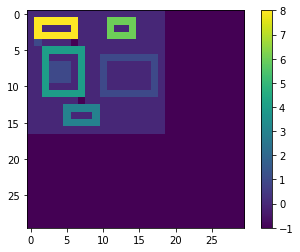

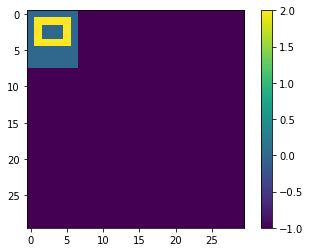

LOSS AT EPOCH 145: 0.0015818737 TRAIN ACCURACY: 0.9930555555555555 VALIDATION ACCURACY: 0.9628482972136223
(4, 30, 30, 18)
[283  56 132 311] [288  56 132 323]


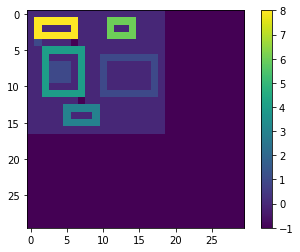

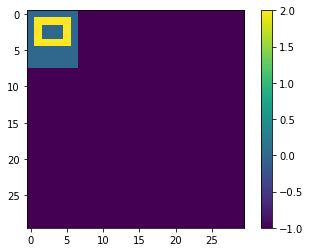

LOSS AT EPOCH 150: 0.0014727103 TRAIN ACCURACY: 0.9942129629629629 VALIDATION ACCURACY: 0.9628482972136223
(4, 30, 30, 18)
[283  56 132 311] [288  56 132 323]


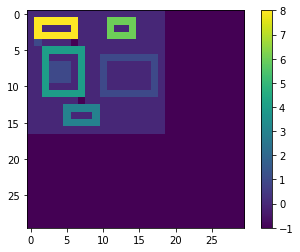

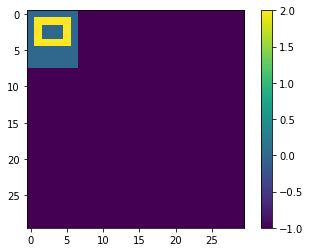

LOSS AT EPOCH 155: 0.0013734887 TRAIN ACCURACY: 0.9942129629629629 VALIDATION ACCURACY: 0.9628482972136223
(4, 30, 30, 18)
[283  56 132 311] [288  56 132 323]


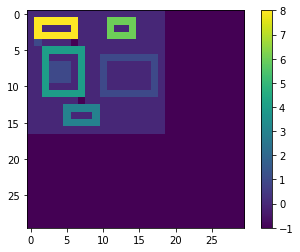

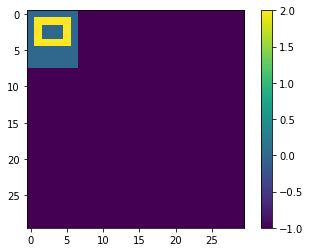

LOSS AT EPOCH 160: 0.0012827931 TRAIN ACCURACY: 0.9942129629629629 VALIDATION ACCURACY: 0.9628482972136223
(4, 30, 30, 18)
[284  56 132 312] [288  56 132 323]


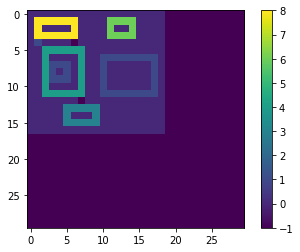

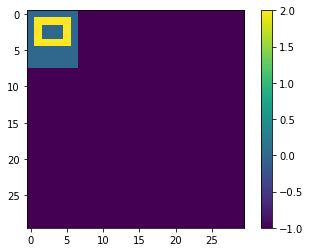

LOSS AT EPOCH 165: 0.0011999239 TRAIN ACCURACY: 0.9953703703703703 VALIDATION ACCURACY: 0.9659442724458205
(4, 30, 30, 18)
[285  56 132 312] [288  56 132 323]


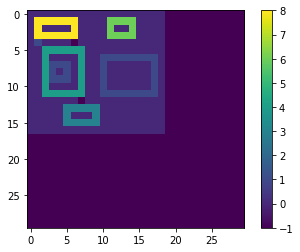

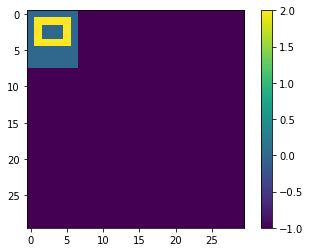

LOSS AT EPOCH 170: 0.0011213569 TRAIN ACCURACY: 0.9965277777777778 VALIDATION ACCURACY: 0.9659442724458205
(4, 30, 30, 18)
[286  56 132 312] [288  56 132 323]


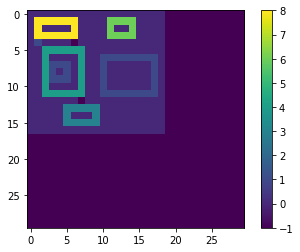

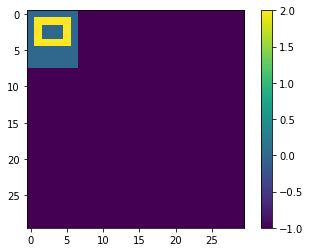

LOSS AT EPOCH 175: 0.0010351574 TRAIN ACCURACY: 0.9976851851851851 VALIDATION ACCURACY: 0.9659442724458205
(4, 30, 30, 18)
[287  56 132 312] [288  56 132 323]


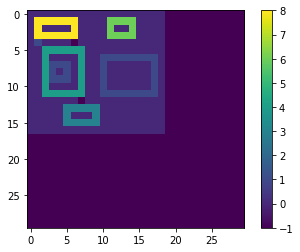

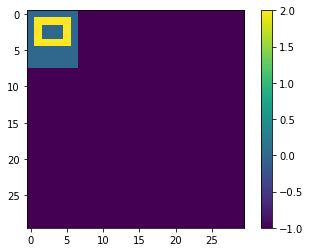

LOSS AT EPOCH 180: 0.0009584121 TRAIN ACCURACY: 0.9988425925925926 VALIDATION ACCURACY: 0.9659442724458205
(4, 30, 30, 18)
[287  56 132 315] [288  56 132 323]


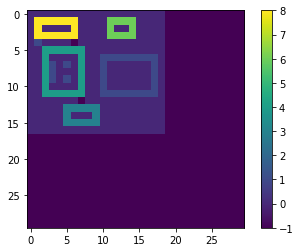

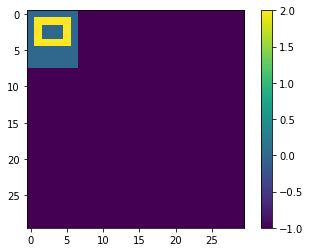

LOSS AT EPOCH 185: 0.0008944529 TRAIN ACCURACY: 0.9988425925925926 VALIDATION ACCURACY: 0.9752321981424149
(4, 30, 30, 18)
[287  56 132 317] [288  56 132 323]


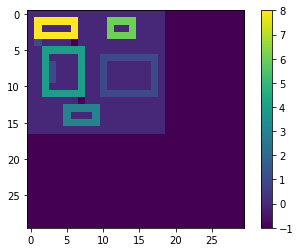

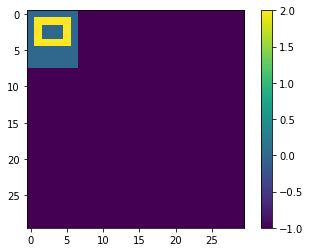

LOSS AT EPOCH 190: 0.0008375197 TRAIN ACCURACY: 0.9988425925925926 VALIDATION ACCURACY: 0.9814241486068112
(4, 30, 30, 18)
[287  56 132 317] [288  56 132 323]


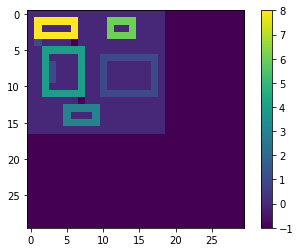

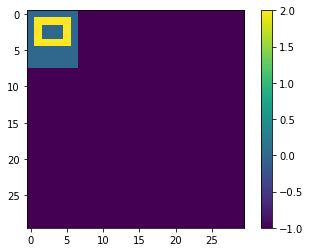

LOSS AT EPOCH 195: 0.00078520924 TRAIN ACCURACY: 0.9988425925925926 VALIDATION ACCURACY: 0.9814241486068112


In [96]:
ntasks = 5
channels = 18
filters = 3
perceptionsize = 3
neurons = 128
epochs = 200
iterations = 25

model = tf.keras.Sequential([
    tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
    tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
])

'''
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters, kernel_size=(perceptionsize, perceptionsize), input_shape=(30, 30, channels), strides=[1, 1], padding="same", activation="relu"),
    tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
])
'''
#311

#295 -- Working
#356 -- Nearly working
ctask = load(names[334])
cin = [ctask[0][0:-1], ctask[1][0:-1]]
ctest = [ctask[0][-1], ctask[1][-1]]
plot(ctest[0])
plot(ctest[1])
model = train(model, cin, epochs, iterations, channels, True, True, ctask)

In [ ]:
ntasks = 5
channels = 20
filters = 5
perceptionsize = 5
neurons = 128
epochs = 200
iterations = 50

model = tf.keras.Sequential([
    tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
    tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels, 1, activation=None),
    tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
    tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
])

#311

#295 -- Working
#356 -- Nearly working
ctask = load(names[295])
cin = [ctask[0][0:-1], ctask[1][0:-1]]
ctest = [ctask[0][-1], ctask[1][-1]]
plot(ctest[0])
plot(ctest[1])
model = train(model, cin, epochs, iterations, channels, True, True, ctask)

In [ ]:
ntasks = 5
channels = 20
filters = 10
perceptionsize = 3
neurons = 128
epochs = 20
iterations = 100

'''THIS WORKS
ntasks = 5
channels = 20
filters = 10
perceptionsize = 3
neurons = 200
epochs = 700
iterations = 100
'''

ranges = {"channels": [5, 70], "filters": [1, 20], "perceptionsize": [3, 7], "neurons": [20, 700], "epochs": [50, 700], "iterations":  [100, 1000]}

cacc = test(ntasks, channels, filters, perceptionsize, neurons, epochs, iterations, True)
print(cacc*100)

In [ ]:
ntasks = 5
channels = 20
filters = 5
perceptionsize = 5
neurons = 128
epochs = 200
iterations = 50

model = tf.keras.Sequential([
    tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
    tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
])

model1 = tf.keras.Sequential([
    tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
    tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
])

model2 = tf.keras.Sequential([
    tf.keras.layers.DepthwiseConv2D((perceptionsize, perceptionsize), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
    tf.keras.layers.Conv2D(neurons, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
])

task = names[235]
ctask = load(task)
print(len(ctask[0]))
plot(ctask[0][1])
plot(ctask[1][1])
cin = [ctask[0][0:-1], ctask[1][0:-1]]
model = train(model, cin, epochs, iterations, channels, True, True, ctask)

print("B FIRST BOOST")

ctask1 = []
ctask1.append(np.clip(np.round(generate(model, ctask[0], channels, iterations)), -1, 9))
ctask1.append(ctask[1])
plot(ctask1[0][1])
plot(ctask1[1][1])
cin1 = [ctask1[0][0:-1], ctask1[1][0:-1]]
model1 = train(model1, cin1, epochs, iterations, channels, True, True, ctask1)

print("B SECOND BOOST")

ctask2 = []
ctask2.append(np.clip(np.round(generate(model1, ctask1[0], channels, iterations)), -1, 9))
ctask2.append(ctask1[1])
plot(ctask2[0][1])
plot(ctask2[1][1])
cin2 = [ctask2[0][0:-1], ctask2[1][0:-1]]
model2 = train(model2, cin2, epochs, iterations, channels, True, True, ctask2)

Define model.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.DepthwiseConv2D((3, 3), input_shape=(30, 30, channels), strides=[1, 1], padding="same", depth_multiplier=filters, activation="relu"),
    tf.keras.layers.Conv2D(128, 1, activation="relu"),
    tf.keras.layers.Conv2D(channels, 1, activation=None, kernel_initializer=tf.zeros_initializer)
])

In [ ]:
current = 10

ctask = load(names[current])
plot(ctask[0][0])
plot(ctask[1][0])

In [ ]:
plot(np.clip(np.round(out), -1, 9))
plot(ctask[1][1])

In [ ]:
testacc(np.clip(np.round(out), -1, 9), ctask[1][1])